In [2]:
# coding: utf-8
'''
Small-scale SWI
Saltwater intrusion model paired with AEM data acquisition
for use with sensitivity analysis
'''


# %matplotlib inline
# %load_ext autoreload
# %autoreload 2

# %aimport SGD,utils
import os
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy.stats as sts
import flopy
import SGD
import config
# import hausdorff_from_dir

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('flopy version: {}'.format(flopy.__version__))
# Name model
modelname = 'homogenous'
tot_it = 10

if sys.platform == "darwin":
    try:
        repo = Path(__file__).parent.parent  # repo-->notebook-->__file__
    except:
        repo = Path('../')  # repo-->notebook-->__file__
    model_ws = repo.joinpath('work', modelname)
elif sys.platform == "win32":
    repo = Path('E:\Projects\DelawareSGD')
    model_ws = os.path.join('E:\Projects\DelawareSGD', 'work', modelname)

# if sys.platform == "darwin":
#     model_ws = Path('/Users/ianpg/Documents/ProjectsLocal/DelawareSGD/work').joinpath(modelname)
# elif sys.platform == "win32":
#     model_ws = Path(r'E:\Projects\DelawareSGD\work').joinpath(modelname)
# #     model_ws = os.path.join('E:\Projects\DelawareSGD','work',modelname)

if not model_ws.exists():
    model_ws.mkdir()

# sys.path.append(repo.joinpath('notebook').as_posix())
sw_exe = config.swexe  # set the exe path for seawat
print('Model workspace:', os.path.abspath(model_ws))

workdir = Path('../')
figdir = workdir.joinpath('work', 'figs')
datadir = workdir.joinpath('data')
objdir = workdir.joinpath('data', 'objs')


# utility functions
def load_obj(dirname, name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'rb') as f:
        return pickle.load(f)


def save_obj(dirname, obj, name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


# Create new MC_file
def create_MC_file():
    import datetime
    ts = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
    MC_dir = Path(os.path.join(m.model_ws, 'MC_expt_' + ts))
    if not MC_dir.exists():
        MC_dir.mkdir()
    m.MC_file = MC_dir.joinpath('expt.txt')
    with m.MC_file.open('w') as wf:
        wf.close
    print(m.MC_file)
    return


# nearest value in array
def find_nearest(array, value):
    import numpy as np
    idx = (np.abs(array - value)).argmin()
    idx.astype('int')
    return array[idx]


# take distance in meters, return column in model
def loc_to_col(locs):
    cols = [int(find_nearest((np.arange(ncol) * delc), loc)) for loc in locs]
    return cols


# make a line across the grid
def get_line(start, end, allrows=1, nrow=None):
    """Bresenham's Line Algorithm
    Produces a list of tuples from start and end
    >>> points1 = get_line((0, 0), (3, 4))
    >>> points2 = get_line((3, 4), (0, 0))
    >>> assert(set(points1) == set(points2))
    >>> print points1
    [(0, 0), (1, 1), (1, 2), (2, 3), (3, 4)]
    >>> print points2
    [(3, 4), (2, 3), (1, 2), (1, 1), (0, 0)]
    """

    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1

    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)

    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2

    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True

    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1

    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1

    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        if allrows == 1:
            if nrow is None:
                nrow = m.nrow
            for row in range(nrow):
                coord = (y, row, x) if is_steep else (x, row, y)
                points.append(coord)
        else:
            coord = (y, x) if is_steep else (x, y)
            points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx

    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    return points


# make all cells=0 above the line from get_line()
# Calculate freshwater head based on column of saltwater above each node
# (rho*g*z)
def shade_above(nlay, nrow, ncol, point_list, third_dim=1):
    import numpy as np
    grd = np.ones((nlay, nrow, ncol), dtype='int')
    ocean_hf = []
    if len(point_list) == 0:
        return grd, ocean_hf
    for (lay, row, col) in point_list:
        grd[lay, :, col] = -1  # assign ocean ibound to -1
        grd[:lay, :, col] = 0  # assign cells above ocean to 0
        hf = densefresh / densesalt * ocean_elev - \
            (densesalt - densefresh) / densefresh * \
            (henry_botm[lay] + .5 * delv)
        for irow in range(nrow):
            ocean_hf.append((int(lay), int(irow), int(col), hf))
    ocean_hf = tuple(np.array(ocean_hf).T)
    ocean_hf = (ocean_hf[0].astype('int'),
                ocean_hf[1].astype('int'),
                ocean_hf[2].astype('int'),
                ocean_hf[3])
    return grd, ocean_hf


def get_ocean_right_edge(m, ocean_line_tuple, startlay=None, col=None):
    import numpy as np
    point_list = []

    if col is None:
        col = m.ncol - 1
    # If there is no vertical side boundary, return bottom-right corner node
    if len(ocean_line_tuple) == 0:
        if startlay is None:
            startlay = 0
    elif max(ocean_line_tuple[0]) == m.nlay:
        startlay = m.nlay
    elif max(ocean_line_tuple[0]) < m.nlay:
        startlay = max(ocean_line_tuple[0])
    for lay in range(startlay, m.nlay):
        for row in range(m.nrow):
            point_list.append((lay, row, col))
    point_list = tuple(np.array(point_list).T)
    return point_list

# create random clay blocks throughout model (quick dirty way to do
# heterogeneity)


def rand_clay_blocks(lithmat, hkClay, numblocks, sizeblocks):
    nlay, nrow, ncol = lithmat.shape
    lay_block = np.random.randint(1, nlay - sizeblocks[0], numblocks)
    row_block = np.random.randint(0, nrow - sizeblocks[1] + 1, numblocks)
    col_block = np.random.randint(1, ncol - sizeblocks[2], numblocks)
    lithmat_blocks = lithmat.copy()
    for i in range(numblocks):
        block_coords = [slice(lay_block[i], lay_block[i] + sizeblocks[0]),
                        slice(row_block[i], row_block[i] + sizeblocks[1]),
                        slice(col_block[i], col_block[i] + sizeblocks[2])]
        lithmat_blocks[block_coords] = hkClay
    return lithmat_blocks


def get_yn_response(prompt):
    while True:
        try:
            resp = str(input(prompt))
        except ValueError:
            print("Sorry, I didn't understand that.")
            continue
        if resp[0] is 'y':
            value = True
            break
        elif resp[0] is 'n':
            value = False
            break
        else:
            print('This didnt work right. Try again')
            continue
    return value


def get_value(prompt):
    while True:
        try:
            resp = str(input(prompt))
            break
        except ValueError:
            print("Sorry, I didn't understand that.")
            continue
    return resp


def check_MC_inputParams():
    if m.MC_file is not None:
        use_existing_MCfile = get_yn_response(
            "m.MC_file already exists, continue using this experiment?")
    else:
        use_existing_MCfile = False
    if use_existing_MCfile:
        if m.inputParams is not None:
            if len(m.inputParams) > 0:
                add_to_inputParams = get_yn_response(
                    "m.inputParams already has entries, do you want to add to it?")
            else:
                add_to_inputParams = False
            if add_to_inputParams:
                pass
            else:
                m.inputParams = {}
        else:
            m.inputParams = {}
    else:
        load_existing_MCfile = get_yn_response("load MC file?")
        if load_existing_MCfile:
            f = get_value("path to MC_file (path/to/test.expt): ")
            m.inputParams = load_obj(Path(f), 'inputParams')
            print('loaded .pkl file!')
        else:
            create_MC_file()
            m.inputParams = {}
    return


def add_pumping_wells(wel_data, ssm_data, n_wells, flx, rowcol, kper):
    itype = flopy.mt3d.Mt3dSsm.itype_dict()
    new_weldata = wel_data
    new_ssmdata = ssm_data
    wel_cells = []
    for k in range(n_wells):
        row, col = rowcol[k]
        for i in range(nper):
            if i in kper:
                for j in range(nlay):
                    # WEL {stress_period: [lay,row,col,flux]}
                    new_weldata[i].append(
                        [j, row, col, -flx[k] * delv_weight[j]])
                    wel_cells.append((j, row, col))
                    # SSM: {stress_period: [lay,row,col,concentration,itype]}
                    # since it's a sink, conc. doesn't matter
                    new_ssmdata[i].append([j, row, col, Cfresh, itype['WEL']])
            else:
                for j in range(nlay):
                    # WEL {stress_period: [lay,row,col,flux]}
                    new_weldata[i].append([j, row, col, 0])
                    # SSM: {stress_period: [lay,row,col,concentration,itype]}
                    # since it's a sink, conc. doesn't matter
                    new_ssmdata[i].append([j, row, col, Cfresh, itype['WEL']])
                    wel_cells.append((j, row, col))
                continue
    wel_cells = tuple(np.array(list(set(wel_cells))).T)
    return new_weldata, new_ssmdata, wel_cells


# Add recharge if desired
def make_rech_array(low=1e-2, high=1e0):
    llow, lhigh = np.log10((low, high))
    rech = np.exp(sts.uniform.rvs(size=1, loc=llow, scale=lhigh - llow)[0])
    return rech / (nrow * ncol)


def add_recharge_cells(recharge_generator, const=1, *args):
    if const == 1:
        rech_data = recharge_generator(*args)
    else:
        rech_data = {}
        for i in range(nper):
            rech_array = recharge_generator(*args)
        rech_data[i] = rech_array
    return rech_data


def sample_dist(distclass, size, writeyn=0, model=None, varname=None, log_backtransf=0, *args):
    smp = distclass.rvs(*args, size=size)
    if log_backtransf == 1:
        smp = tuple([10**x for x in smp])
    if size == 1:
        smp = smp[-1]
    if writeyn == 1:
        write_sample(model.MC_file, varname, distclass, smp)
    return smp


def write_sample(fname, varname, distclass, sample):
    fout = open(fname, "a")
    fout.write(varname + ',' + str(type(distclass)) + ',' + str(sample) + '\n')
    fout.close()
    return


def truncate_grf(grid, lith_props, hk_vals, log10trans=True, plotyn=False, saveyn=False):
    grid_cutoffs = []
    for q in np.cumsum(lith_props):
        grid_cutoffs.append(np.quantile(grid, q))

    if plotyn:
        h = plt.hist(grid.flatten())
        for cutoff in grid_cutoffs:
            plt.vlines(cutoff, 0, 14000)
        plt.show()

    outgrid = np.ones(grid.shape, dtype=np.float32)
    for i, cutoff in reversed(list(enumerate(grid_cutoffs))):
        outgrid[np.where(grid < cutoff)] = hk_vals[i]

    if plotyn:
        f, axs = plt.subplots(2, 1, sharex=True)
        axs[0].imshow(grid[:, 0, :])
        axs[1].imshow(outgrid[:, 0, :])
        if saveyn:
            plt.savefig(m.MC_file.parent.joinpath(
                'Truncated_GRF.png').as_posix(), resolution=300)
    if log10trans:
        return np.power(10, outgrid)
    else:
        return outgrid

def make_timestamp(YMD=True,HM=True):
    import datetime
    if YMD:
        ymd = '%Y%m%d'
    else:
        ymd = ''
    if HM:
        hm = '%H%M'
    else:
        hm = ''
    if YMD and HM:
        sep = '_'
    else:
        sep = ''
    return datetime.datetime.now().strftime('{}{}{}'.format(ymd,sep,hm))

    
#%%
# Name model


def pec_num(delv, delc, delr, al):
    delL = (delv, delc, delr)  # length in the lay,row,col directions
    pec_num = [round(d / al, 2) for d in delL]
    for num, point in zip(pec_num, ('lay', 'row', 'col')):
        print('Pe = {} in the {} direction'.format(num, point))
    return pec_num
#%%

sw_exe = config.swexe  # set the exe path for seawat
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('flopy version: {}'.format(flopy.__version__))
print('Model workspace:', os.path.abspath(model_ws))
# Model grid
# Grid: 0.5 *1*1m • Size:70m*20m

Lx = 3000.
Ly = 600.
Lz = 80.

henry_top = 3
ocean_elev = 0
delv_first = 5


botm_first = henry_top - delv_first

nlay = int(Lz * 1 / 3)
nrow = int(Ly * (1 / 30))
ncol = int(Lx * (1 / 30))

delv = (Lz - delv_first) / (nlay - 1)
delr = Lx / ncol
delc = Ly / nrow

henry_botm = np.hstack(([botm_first], np.linspace(
    botm_first - delv, henry_top - Lz, nlay - 1)))
delv_vec = np.hstack((delv_first, np.repeat(delv, nlay - 1)))
delv_weight = [x / np.sum(delv_vec) for x in delv_vec]


3.6.7 | packaged by conda-forge | (default, Feb 28 2019, 02:16:08) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.16.3
flopy version: 3.3.0
Model workspace: /Volumes/Samsung_T5/ProjectsLocal/SWIlarge/work/homogenous
3.6.7 | packaged by conda-forge | (default, Feb 28 2019, 02:16:08) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.16.3
flopy version: 3.3.0
Model workspace: /Volumes/Samsung_T5/ProjectsLocal/SWIlarge/work/homogenous


In [55]:
save_obj(m.MC_file.parent,farm_loc_list,'farm_loc_list')

In [58]:
basecase_ws = m.MC_file.parent.parent.parent.joinpath('base_case_3m')
save_obj(basecase_ws,riv_loc,'riv_loc')

In [10]:
#Name model
modelname = 'test_simpleSWI'


import os
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy.stats as sts
import flopy

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('flopy version: {}'.format(flopy.__version__))
# Name model

if sys.platform == "darwin":
    try:
        repo = Path(__file__).parent.parent  # repo-->notebook-->__file__
    except:
        repo = Path('../')  # repo-->notebook-->__file__
    model_ws = repo.joinpath('work', modelname)
elif sys.platform == "win32":
    repo = Path('E:\Projects\DelawareSGD')
    model_ws = os.path.join('E:\Projects\DelawareSGD', 'work', modelname)
    #model_ws = repo.joinpath('work', modelname)
    
    
if not os.path.exists(model_ws):
    os.mkdir(model_ws)


if repo.as_posix() not in sys.path:
    sys.path.append(repo.as_posix())
import SGD
import config
import hausdorff_from_dir




# sys.path.append(repo.joinpath('notebook').as_posix())
sw_exe = config.swexe  # set the exe path for seawat
print('Model workspace:', model_ws)

workdir = Path('../')
figdir = workdir.joinpath('work', 'figs')
datadir = workdir.joinpath('data')
objdir = workdir.joinpath('data', 'objs')




#%% Useful functions

def load_obj(dirname,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'rb') as f:
        return pickle.load(f)

def save_obj(dirname,obj,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#Create new MC_file
def create_MC_file():
    import datetime
    ts = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
    MC_dir = Path(os.path.join(m.model_ws, 'MC_expt_' + ts))
    if not MC_dir.exists():
        MC_dir.mkdir()
    m.MC_file = MC_dir.joinpath('expt.txt')
    with m.MC_file.open('w') as wf:
        wf.close
    print(m.MC_file)
    return

#nearest value in array
def find_nearest(array,value):
    import numpy as np
    idx = (np.abs(array-value)).argmin()
    idx.astype('int')
    return array[idx]

#take distance in meters, return column in model
def loc_to_col(locs):
    cols = [int(find_nearest((np.arange(ncol)*delc),loc)) for loc in locs]
    return cols

#make a line across the grid
def get_line(start, end,allrows=1,nrow=None):
    """Bresenham's Line Algorithm
    Produces a list of tuples from start and end

    >>> points1 = get_line((0, 0), (3, 4))
    >>> points2 = get_line((3, 4), (0, 0))
    >>> assert(set(points1) == set(points2))
    >>> print points1
    [(0, 0), (1, 1), (1, 2), (2, 3), (3, 4)]
    >>> print points2
    [(3, 4), (2, 3), (1, 2), (1, 1), (0, 0)]
    """
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1

    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)

    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2

    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True

    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1

    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1

    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        if allrows==1:
            if nrow is None:
                nrow = m.nrow
            for row in range(nrow):
                coord = (y, row, x) if is_steep else (x, row, y)
                points.append(coord)
        else:
            coord = (y, x) if is_steep else (x, y)
            points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx

    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    return points


#make all cells=0 above the line from get_line()
#Calculate freshwater head based on column of saltwater above each node (rho*g*z)
def shade_above(nlay,nrow,ncol,point_list,third_dim=1):
    import numpy as np
    grd = np.ones((nlay,nrow,ncol),dtype='int')
    ocean_hf = []
    if len(point_list)==0:
        return grd,ocean_hf
    for (lay,row,col) in point_list:
        grd[lay,:,col] = -1 #assign ocean ibound to -1
        grd[:lay,:,col] = 0 #assign cells above ocean to 0
        hf = densefresh/densesalt*ocean_elev - (densesalt - densefresh)/densefresh*(henry_botm[lay] +.5*delv)
        for irow in range(nrow):
            ocean_hf.append((int(lay),int(irow),int(col),hf))
    ocean_hf = tuple(np.array(ocean_hf).T)
    ocean_hf = (ocean_hf[0].astype('int'),
                ocean_hf[1].astype('int'),
                ocean_hf[2].astype('int'),
                ocean_hf[3])
    return grd,ocean_hf

def get_ocean_right_edge(m,ocean_line_tuple,startlay=None,col=None):
    import numpy as np
    point_list = []
    if col is None:
        col = m.ncol-1
    #If there is no vertical side boundary, return bottom-right corner node
    if len(ocean_line_tuple)==0:
        if startlay is None:
            startlay = 0
    elif max(ocean_line_tuple[0])==m.nlay:
        startlay = m.nlay
    elif max(ocean_line_tuple[0])<m.nlay:
        startlay = max(ocean_line_tuple[0])
    for lay in range(startlay,m.nlay):
        for row in range(m.nrow):
            point_list.append((lay,row,col))
    point_list = tuple(np.array(point_list).T)
    return point_list

def add_pumping_wells(wel_data,ssm_data,n_wells,flx,rowcol,kper):
    itype = flopy.mt3d.Mt3dSsm.itype_dict()
    new_weldata = wel_data
    new_ssmdata = ssm_data
    wel_cells = []
    for k in range(n_wells):
        row,col = rowcol[k]
        for i in range(nper):
            if i in kper:
                for j in range(nlay):
                    #WEL {stress_period: [lay,row,col,flux]}
                    new_weldata[i].append([j,row,col,-flx[k]*delv_weight[j]])
                    wel_cells.append((j,row,col))
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    new_ssmdata[i].append([j,row,col,Cfresh,itype['WEL']]) #since it's a sink, conc. doesn't matter
            else:
                for j in range(nlay):
                    #WEL {stress_period: [lay,row,col,flux]}
                    new_weldata[i].append([j,row,col,0])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    new_ssmdata[i].append([j,row,col,Cfresh,itype['WEL']]) #since it's a sink, conc. doesn't matter
                    wel_cells.append((j,row,col))
                continue
    wel_cells = tuple(np.array(list(set(wel_cells))).T)
    return new_weldata, new_ssmdata,wel_cells

#Add recharge if desired
def make_rech_array(low=1e-2,high=1e0):
    import scipy.stats as sts
    llow,lhigh = np.log10((low,high))
    rech = np.exp(sts.uniform.rvs(size=1,loc=llow,scale=lhigh-llow)[0])
    return rech/(nrow*ncol)

def add_recharge_cells(recharge_generator,const=1,*args):
    if const==1:
        rech_data = recharge_generator(*args)
    else:
        rech_data = {}
        for i in range(nper):
            rech_array = recharge_generator(*args)
        rech_data[i] = rech_array
    return rech_data

def sample_dist(distclass,size,*args):
    smp = distclass.rvs(*args,size=size)
    if size==1:
        smp=smp[-1]
    return smp

def write_sample(fname,varname,distclass,sample):
    fout= open(fname,"a")
    fout.write(varname + ',' + str(type(distclass)) + ',' + str(sample) + '\n')
    fout.close()
    return

def truncate_grf(grid,lith_props,hk_vals,log10trans=True,plotyn=False,saveyn=False):
    grid_cutoffs = []
    for q in np.cumsum(lith_props):
        grid_cutoffs.append(np.quantile(grid,q))

    if plotyn:
        h = plt.hist(grid.flatten())
        for cutoff in grid_cutoffs:
            plt.vlines(cutoff,0,14000)
        plt.show()

    outgrid = np.ones(grid.shape,dtype=np.float32)
    for i,cutoff in reversed(list(enumerate(grid_cutoffs))):
        outgrid[np.where(grid<cutoff)] = hk_vals[i]

    if plotyn:
        f,axs = plt.subplots(2,1,sharex=True)
        axs[0].imshow(grid[:,0,:])
        axs[1].imshow(outgrid[:,0,:])
        if saveyn:
            plt.savefig(m.MC_file.parent.joinpath('Truncated_GRF.png').as_posix(),resolution=300)
    if log10trans:
        return np.power(10,outgrid)
    else:
        return outgrid

def make_timestamp(YMD=True,HM=True):
    import datetime
    if YMD:
        ymd = '%Y%m%d'
    else:
        ymd = ''
    if HM:
        hm = '%H%M'
    else:
        hm = ''
    if YMD and HM:
        sep = '_'
    else:
        sep = ''
    return datetime.datetime.now().strftime('{}{}{}'.format(ymd,sep,hm))

def pec_num(delv,delc,delr,al):
    delL = (delv,delc,delr) #length in the lay,row,col directions
    pec_num = [round(d/al,2) for d in delL]
    for num,point  in zip(pec_num,('lay','row','col')):
        print('Pe = {} in the {} direction'.format(num,point))
    return pec_num

#%%
#Name model



sw_exe = config.swexe #set the exe path for seawat
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('flopy version: {}'.format(flopy.__version__))

#Model discretization
#Lx = 2000.
Lx = 3000.
Ly = 600.
Lz = 80.

nlay = int(Lz/3)
nrow = int(Ly/30)
ncol = int(Lx/30)
#Lx = 300.
#Ly = 100.
#Lz = 20.
#nlay = int(Lz/3)
#nrow = int(Ly/3)
#ncol = int(Lx/3)

dim = tuple([int(x) for x in (nlay,nrow,ncol)])

henry_top = 3.3
ocean_elev = 0

#delv_first = Lz/nlay
delv_first = 4
botm_first = henry_top-delv_first

delv = (Lz-delv_first) / (nlay-1)
delr = Lx / ncol
delc = Ly / nrow

henry_botm = np.hstack(([botm_first],np.linspace(botm_first-delv,henry_top-Lz,nlay-1)))
delv_vec = np.hstack((delv_first,np.repeat(delv,nlay-1)))
delv_weight = [x/np.sum(delv_vec) for x in delv_vec]

beachslope = .05
ocean_col = [np.floor(ncol-1).astype('int'),ncol-1] #Manually done to make sure it's in the right place rn
inland_elev = beachslope*ocean_col[0]*delr
offshore_elev = -beachslope*(ocean_col[1]-ocean_col[0])*delr


#Period data
nyrs= 1
Lt = 360*nyrs #Length of time in days
perlen = list(np.repeat(180,int(Lt/180)))
nstp = list(np.ones(np.shape(perlen),dtype=int))

nper = len(perlen)
steady = [False for x in range(len(perlen))] #Never steady
itmuni = 4 #time unit 4= days
lenuni = 2 #length unit 2 = meter
tsmult = 1.8
ssm_data = None
verbose = True

print('Model setup: \n'
      'nlay: {}\n'
      'nrow: {}\n'
      'ncol: {}\n'
      'Total cells: {}\n'
      'Total time: {} days\n'
      'nper: {}\n'.format(nlay,nrow,ncol,nlay*nrow*ncol,Lt,nper))
# In[4]:

#Create basic model instance and dis pacakge
m = flopy.seawat.Seawat(modelname, exe_name=sw_exe, model_ws=model_ws,verbose=verbose)
SGD.ModelSGD.Seawat2SGD(m)  #convert to subclass ModelSGD
print(m.namefile)

# Add DIS package to the MODFLOW model
dis = flopy.modflow.ModflowDis(m, nlay, nrow, ncol, nper=nper, delr=delr,
                               delc=delc,
                               laycbd=0, top=henry_top,
                               botm=henry_botm, perlen=perlen, nstp=nstp,
                               steady=steady,itmuni=itmuni,lenuni=lenuni,
                               tsmult=tsmult)
create_MC_file()
# In[5]:

#Hydraulic conductivity field
hkSand = 1e2  #horizontal hydraulic conductivity m/day
hkClay = hkSand*.01

heterogenous = 0 #0:homogenous,1:variogram,2:MPS
clay_lyr = True


if heterogenous==1:
    import simulationFFT
    mu = np.log(hkSand)
    sill = .1
    modeltype = 'Exponential'
    llay = int(20/np.mean(delv))
    lrow = int(2000/delc)
    lcol = int(2000/delr)

    fft_grid = np.exp(simulationFFT.simulFFT(nrow, nlay, ncol, mu, sill, modeltype, lrow , llay, lcol))
    grid = np.log10(fft_grid)
    #lith_props = [0.2,0.5,0.3]
    #hk_vals = [-1,0,2]
    lith_props = [0.2,0.8]
    hk_vals = [0,2]

    log10trans = True
    plotyn=True
    hk = truncate_grf(grid,lith_props,hk_vals,log10trans=True,plotyn=False,saveyn=True)
    
    if clay_lyr:
        lyr_ind = np.where((henry_botm<-2) & (henry_botm >-15))
        hk[lyr_ind,:,:int(ncol*3/4)] = 10**hk_vals[0]
        if plotyn:
            plt.imshow(hk[:,0,:])
    
# elif heterogenous==2:
#     import sgs_mod
#     nodes = 20
#     marg = .5
#     search_ellipse=(2000,500,20,0,0,0) #(max,med,min,az,dip,rake)
#     grid_size = (Lz,Ly,Lx)
#     grid_cells = dim
#     rotind= [1,2,0] #simulation in a Y,X,Z grid
#     constrain=1
#     expgridfile,outgrid,rotind,grid_cells_sgems = sgs_mod.snesim_grid(m.name, Path(model_ws),
#                                               grid_size,grid_cells,search_ellipse=search_ellipse,
#                                               TIfile=None,TIname=None,marg=marg,seed=1,nodes=nodes,
#                                               nreals=1,output=False,rmfiles=False,rotind=rotind,constrain=constrain)
#     outgrid = sgs_mod.read_sgems_grid(expgridfile,grid_cells,grid_cells_sgems)
#     outgrid = outgrid.squeeze()
#     hk = np.zeros(dim,dtype=np.float)
#     hk[np.where(outgrid==0)]=hkClay
#     hk[np.where(outgrid==1)]=hkSand
#     f,axs = plt.subplots(2,1,sharex=True)
#     plt.sca(axs[0])
#     plt.imshow(hk[-3,:,:])
#     axs[0].set_title('top view')
#     plt.sca(axs[1])
#     plt.imshow(hk[:,0,:])
#     axs[1].set_title('side view')
else:
    hk = hkSand*np.ones((nlay,nrow,ncol), dtype=np.int32)

#plt.figure(),plt.imshow((hk[:,0,:])),plt.colorbar(),plt.title('Sill:{}'.format(sill)),plt.show()

#Set Hydraulic properties
sy = 0.24
ss = 1e-5
por = 0.3
vka = 1 # = vk/hk
al = 1 #longitudinal dispersivity (m) from Walther et al. 2017
dmcoef = 2e-9 #m2/day

#Variable density parameters
Csalt = 35.0001
Cfresh = 0.
densesalt = 1025.
densefresh = 1000.
denseslp = (densesalt - densefresh) / (Csalt - Cfresh)
#denseslp = 0 #trick for testing constant density



# In[8]:
#Winter is even stress periods, summer is odd SP.
#Winter= wells OFF, natural precip (rech) ON, irrigation rech OFF,
#Summer = wells ON, irrigation rech (farm_rech) ON,  precip (rech) OFF
kper_odd = list(np.arange(1,nper,2))
kper_even = list(np.arange(0,nper,2))

#BCs
bc_ocean = 'GHB'
bc_right_edge = 'GHB'
bc_inland = 'GHB'
add_wells = 0
n_wells = 0
rech_on = 0

#Inland
calc_inland_head = 0 #calculate from hgrad
manual_inland_head = 0.3184
start_fresh_yn = 1
ocean_shead = [ocean_elev for x in range(len(perlen))]
ocean_ehead = ocean_shead

# save cell fluxes to unit 53
ipakcb = 53

#Create ocean boundary at top of model
ocean_col_vec = (0,0,np.arange(ocean_col[0],ocean_col[1]+1))
ocean_coords = (0,slice(0,nrow),slice(ocean_col[0],ocean_col[1]+1)) #top of the model
ocean_bool = np.zeros((nlay,nrow,ncol), dtype=bool)
ocean_bool[0,:,np.arange(ocean_col[0],ocean_col[1]+1)] = 1
m.ocean_arr = ocean_bool


if calc_inland_head == 1:
    head_inland = ocean_col[0]*delc*hgrad + ocean_elev
else:
    head_inland = manual_inland_head

####IN TESTING#####
#Create a line of where the ocean is, and any nodes on right edge below ocean
offshore_lay = (np.abs(henry_botm-offshore_elev)).argmin().astype('int')
if ocean_col[0] == ncol-1:
    ocean_line = []
    bc_ocean = 'XXX'
else:
    ocean_line = get_line((0,ocean_col[0]),(offshore_lay,ocean_col[1]),allrows=1,nrow=1)

ocean_line_tuple = tuple(np.array(ocean_line).T) #use this for indexing numpy arrays
right_edge = get_ocean_right_edge(m,ocean_line_tuple,
                                  int(np.where(henry_botm==find_nearest(henry_botm,ocean_elev))[0]))
left_edge = get_ocean_right_edge(m,ocean_line_tuple,
                                  int(np.where(henry_botm==find_nearest(henry_botm,head_inland))[0]),
                                col=0)

#Create ibound
ibound,ocean_hf = shade_above(nlay,nrow,ncol,ocean_line) #don't set ibound of ocean
#ibound[:right_edge[0][0],right_edge[1][0],right_edge[2][0]] = 0
#ibound[:right_edge[0][0],right_edge[1][0],0] = 0

if bc_ocean == 'GHB':
    ibound[ocean_line_tuple]=1


#Set starting heads
strt = np.ones((nlay,nrow,ncol),dtype=np.int)+3


#Transport BCs
if start_fresh_yn == 1:
    sconc = Cfresh*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin fresh
elif start_fresh_yn == 0:
    sconc = Csalt*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin SW-saturated
else:
    sconc = Cfresh*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin SW-saturated
    sconc[:,:,int(np.floor(ncol/2)):-1] = Csalt

if ocean_hf:
    sconc[ocean_hf[0:3]] = Csalt
sconc[right_edge] = Csalt
sconc[:,:,0] = Cfresh

icbund = np.ones((nlay, nrow, ncol), dtype=np.int)
icbund[np.where(ibound==-1)] = -1

head_inland_sum_wint = (3.0,3.0) #m in summer, m in winter

def make_bc_dicts(head_inland_sum_wint=head_inland_sum_wint):
    #Ocean and inland boundary types
    itype = flopy.mt3d.Mt3dSsm.itype_dict()
    chd_data = {}
    ssm_data = {}
    ghb_data = {}
    wel_data = {}
    for i in range(nper):
        dat_chd = []
        dat_ssm = []
        dat_ghb = []
        dat_wel = []
        #Ocean boundary
        if ocean_hf:
            for j in range(np.size(ocean_hf[0])):
                if bc_ocean=='CHD':
                    #CHD: {stress_period: [lay,row,col,starthead,endhead]}
                    dat_chd.append([ocean_line_tuple[0][j],
                                ocean_line_tuple[1][j],
                                ocean_line_tuple[2][j],
                                ocean_shead[i],
                                ocean_ehead[i]])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    dat_ssm.append([ocean_line_tuple[0][j],
                                ocean_line_tuple[1][j],
                                ocean_line_tuple[2][j],
                                Csalt,
                                itype['CHD']])
                elif bc_ocean=='GHB':
                    #GHB: {stress period: [lay,row,col,head level,conductance]}
                    #conductance c = K*A/dL; assume horizontal flow at outlet,
                    #and calculate length to be at edge of ocean cell, as opposed to mipoint
                    # c = (K*dy*dz)/(dx/2) = 2*K*delr*delv/delc
                    dat_ghb.append([ocean_hf[0][j],
                                   ocean_hf[1][j],
                                   ocean_hf[2][j],
                                   #ocean_hf[3][j],
                                    ocean_elev,
                                   2*hkSand*delc*delv_vec[ocean_hf[0][j]]/delr])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    dat_ssm.append([ocean_hf[0][j],
                                   ocean_hf[1][j],
                                   ocean_hf[2][j],
                                   Csalt,
                                   itype['GHB']])
        else:
            pass
        #Right edge boundary
        if bc_right_edge=='GHB':
            for j in range(np.size(right_edge[0])):
                #GHB: {stress period: [lay,row,col,head level,conductance]}
                #conductance c = K*A/dL; assume horizontal flow at outlet,
                #and calculate length to be at edge of ocean cell, as opposed to mipoint
                # c = (K*dy*dz)/(dx/2) = 2*K*delr*delv/delc
                dat_ghb.append([right_edge[0][j],
                               right_edge[1][j],
                               right_edge[2][j],
                               #ocean_hf[3][j],
                                ocean_elev,
                               2*hkSand*delc*delv_vec[right_edge[0][j]]/delr])
                #SSM: {stress_period: [lay,row,col,concentration,itype]}
                dat_ssm.append([right_edge[0][j],
                               right_edge[1][j],
                               right_edge[2][j],
                               Csalt,
                               itype['GHB']])
        else:
            pass
        #Inland boundary
        if bc_inland=='GHB':
            if i in kper_odd:
                head_inland = head_inland_sum_wint[0]
            elif i in kper_even:
                head_inland = head_inland_sum_wint[1]
            left_edge = get_ocean_right_edge(m,ocean_line_tuple,
                  int(np.where(henry_botm==find_nearest(henry_botm,head_inland))[0]),
                col=0)
            for j in range(np.size(left_edge[0])):
                dat_ghb.append([left_edge[0][j],
                               left_edge[1][j],
                               left_edge[2][j],
                                head_inland,
                               2*hkSand*delc*delv_vec[left_edge[0][j]]/delr])
                #SSM: {stress_period: [lay,row,col,concentration,itype]}
                dat_ssm.append([left_edge[0][j],
                               left_edge[1][j],
                               left_edge[2][j],
                               Cfresh,
                               itype['GHB']])
        elif bc_inland=='WEL':
            for j in range(nlay):
                for k in range(nrow):
                    #WEL: {stress_period: [lay,row,col,flux]}
                    dat_wel.append([j,k,0,influx*delv_weight[j]/nrow])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    dat_ssm.append([j,k,0,Cfresh,itype['WEL']])
        chd_data[i] = dat_chd
        ssm_data[i] = dat_ssm
        ghb_data[i] = dat_ghb
        wel_data[i] = dat_wel

    #saving concentrations at specified times
    #timprs = [k for k in range(1,np.sum(perlen),50)]
    return chd_data, ssm_data, ghb_data, wel_data

chd_data, ssm_data, ghb_data, wel_data = make_bc_dicts(head_inland_sum_wint)
wel_data_base,ssm_data_base = wel_data,ssm_data
timprs = np.round(np.linspace(1,np.sum(perlen),20),decimals=0)

save_obj(m.MC_file.parent,wel_data_base,'wel_data_base')
save_obj(m.MC_file.parent,ssm_data_base,'ssm_data_base')


3.6.7 | packaged by conda-forge | (default, Feb 28 2019, 02:16:08) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.16.3
flopy version: 3.3.0


ModuleNotFoundError: No module named 'hausdorff_from_dir'

In [104]:
basecase_ws = Path('/Users/ianpg/Documents/ProjectsLocal/SWIsmall/work/base_case_3m')

fpath = basecase_ws.joinpath('homogenous.nam').absolute().as_posix()

In [102]:
flopy.seawat.Seawat.load(fpath)

In [108]:
import glob
for f in basecase_ws.iterdir():
    f.rename(f.parent.joinpath('case_base' + f.suffix))



In [111]:
basecase_ws =  Path('../work/homog/')

save_obj(basecase_ws,wel_cells,'wel_cells')
save_obj(basecase_ws,right_edge,'right_edge')
save_obj(basecase_ws,farm_loc_list,'farm_loc_list')
save_obj(basecase_ws,riv_loc,'riv_loc')


In [112]:
basecase_ws.joinpath(basecase_ws.parts[-1] + '.nam')

PosixPath('../work/homog/homog.nam')

In [115]:
fpath_basecase = basecase_ws.joinpath(basecase_ws.parts[-1] + '.nam').as_posix()

os.path.split(fpath_basecase)[0]


('../work/homog', 'homog.nam')

In [50]:
m.dis.delc.array[0], m.dis.delr.array[0]


array([30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
       30., 30., 30., 30., 30., 30., 30.], dtype=float32)

In [45]:
mu = np.log(hkSand)
sill = .1
modeltype = 'Exponential'
llay = int(20 / np.mean(delv))
lrow = int(2000 / delc)
lcol = int(2000 / delr)

fft_grid = np.exp(simulationFFT.simulFFT(
    nrow, nlay, ncol, mu, sill, modeltype, lrow, llay, lcol))
grid = np.log10(fft_grid)

SGD.ModelSGD

In [99]:
# In[134]:


# ## Post-processing results

# In[17]:

# Post-processing functions

def plotdischarge(modelname, model_ws, color='w', per=-1, scale=50, rowslice=0):
    fname = os.path.join(model_ws, '' + modelname + '.cbc')
    budobj = flopy.utils.CellBudgetFile(fname)
    qx = budobj.get_data(text='FLOW RIGHT FACE')[per]
    qz = budobj.get_data(text='FLOW LOWER FACE')[per]

    # Average flows to cell centers
    qx_avg = np.empty(qx.shape, dtype=qx.dtype)
    qx_avg[:, :, 1:] = 0.5 * (qx[:, :, 0:ncol - 1] + qx[:, :, 1:ncol])
    qx_avg[:, :, 0] = 0.5 * qx[:, :, 0]
    qz_avg = np.empty(qz.shape, dtype=qz.dtype)
    qz_avg[1:, :, :] = 0.5 * (qz[0:nlay - 1, :, :] + qz[1:nlay, :, :])
    qz_avg[0, :, :] = 0.5 * qz[0, :, :]

    y, x, z = dis.get_node_coordinates()
    X, Z = np.meshgrid(x, z[:, 0, 0])
    iskip = 1  # how many cells to skip, 1 means plot every cell

    ax = plt.gca()
    cpatchcollection = ax.quiver(X[::iskip, ::iskip], Z[::iskip, ::iskip],
                                 qx_avg[::iskip, rowslice, ::iskip], -
                                 qz_avg[::iskip, rowslice, ::iskip],
                                 color=color, scale=scale, headwidth=4, headlength=2,
                                 headaxislength=1, width=0.0025)
    return cpatchcollection


def permute_kstpkper(ucnobj):
    kstpkper = ucnobj.get_kstpkper()
    kstpkper_unique = []
    index_unique = []
    niter = 0
    for entry in kstpkper:
        if not entry in kstpkper_unique:
            kstpkper_unique.append(entry)
            index_unique.append(niter)
        niter += 1
    return kstpkper_unique, index_unique


def kstpkper_from_time(ucnobj, tottim):
    kstpkpers = ucnobj.get_kstpkper()
    times = ucnobj.get_times()
    timeind = times.index(tottim)
    kstpkper = kstpkpers[timeind]
    return kstpkper


def kstpkper_ind_from_kstpkper(ucnobj, kstpkper=(0, 0)):
    kstpkpers = ucnobj.get_kstpkper()
    kstpkper_unique = permute_kstpkper(ucnobj)[0]
    kstpkper_ind = kstpkper_unique.index(kstpkper)
    return kstpkper_ind


def get_salt_outflow(m, kstpkper=None, totim=None):
    fname = os.path.join(m.model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.binaryfile.UcnFile(fname)
    totim = ucnobj.get_times()[-1]
    if kstpkper == None:
        kstpkper = ucnobj.get_kstpkper()[-1]
    ocean_conc = ucnobj.get_data(kstpkper=kstpkper)
    return ocean_conc


def plot_background(mm, array, label=None):
    if label == None:
        label = [k for k, v in globals().items() if v is array][-1]
    if label == 'hk':
        norm = matplotlib.colors.LogNorm()
        vmin = hkClay
        vmax = hkSand
        cmap = 'jet'
    else:
        norm = None
        vmin = None
        vmax = None
        cmap = 'jet'
    cpatchcollection = mm.plot_array(
        array, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)
    cpatchcollection.set_label(label)
    return cpatchcollection, label


def plot_mas(m):
    # Load the mas file and make a plot of total mass in aquifer versus time
    fname = os.path.join(m.model_ws, 'MT3D001.MAS')
    mas = flopy.mt3d.Mt3dms.load_mas(fname)
    f = plt.figure()
    ax = f.add_subplot(1, 1, 1)
    plt.xlabel('Time (d)')
    plt.ylabel('Mass (kg)')
    plt.title('Mass of salt within model through time')
    ax.plot(mas.time, mas.total_mass)
    plt.show()
    return mas


def add_to_paramdict(paramdict, paramname, val):
    if paramdict is None:
        paramdict = {}
    if paramname in list(paramdict.keys()):
        paramdict[paramname].append(val)
    else:
        # paramdict.update(paramname=[val])
        paramdict[paramname] = [val]
    return


def record_salinity(m, totim=None, fname_write=None, ts_hms=None):
    if ts_hms is None:
        ts_hms = datetime.datetime.now().strftime('%H-%M-%S')
    # Extract final timestep salinity
    fname = os.path.join(m.model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.binaryfile.UcnFile(fname)
    if totim is None:
        totim = ucnobj.get_times()[-1]
    conc = ucnobj.get_data(totim=totim)
    if fname_write is None:
        fname_write = m.MC_file.parent.joinpath(
            'conc_' + str(int(totim)) + '_' + ts_hms + '.npy')
        print(fname_write)
        np.save(fname_write, conc)
    return conc


def copy_rename(src_file, dst_file):
    import shutil
    from pathlib import Path
    shutil.copy(str(Path(src_file)), str(Path(dst_file)))
    return


def idx2centroid(node_coord_tuple, idx_tuple):
    z_pt = node_coord_tuple[2][idx_tuple]
    x_pt = node_coord_tuple[1][idx_tuple[2]]
    y_pt = node_coord_tuple[0][idx_tuple[1]]
    return (z_pt, y_pt, x_pt)


def sample_uniform(low, high, shape, logyn):
    '''
    #Samples a uniform distribution the nummber of times shown in 
    low: low value in dist
    high: high value in dist
    shape: shape of samples
    logyn: if True, samples as a log-normal distribution. 
        If False, samples as a uniform distribution. Returned values are *not* in logspace  
    '''

    if logyn:
        log_param_list = np.random.uniform(np.log(low), np.log(high), shape)
        param_list = np.exp(log_param_list)
    else:
        param_list = np.random.uniform(low, high, shape)
    return param_list

def normal_transform(data1,mu1,mu2,sig1,sig2):
    a = sig2/sig1
    b = mu2 - mu1 * a
    return a*data1 + b

################# Creating varlist ################
from scipy.io import savemat

tot_it = 2
seed = 1
np.random.seed(seed)
varlist = {}

# In[23]:
#Load certain variables:
# values_dir = repo.joinpath('data/values_for_distributions')
# rech_farm = load_obj(values_dir,'rech_rng_farm')
# rech_precip_sum,rech_precip_wint= load_obj(values_dir,'rech_rng_precip')
# ghb_inland_sum,ghb_inland_wint = load_obj(values_dir,'ghb_rng_model_edge')
# wel_rng_mpday = load_obj(values_dir,'wel_rng_mday')
# wel_rng_m3pday = np.r_[wel_rng_mpday]*np.prod(farm_size)

#head_inland_sum
logyn = False
low = -1.1
high = 0
varlist['head_inland_sum'] = sample_uniform(low, high, tot_it, logyn)


#head_inland_wint
logyn = False
low = 0
high = 3
varlist['head_inland_wint'] = sample_uniform(low, high, tot_it, logyn)

if heterogenous==0:
#HOMOGENOUS ONLY
    # log_hk
    logyn = True
    low = 80
    high = 80
    varlist['hk'] = sample_uniform(low, high, tot_it, logyn)

    ##por: porosity
    logyn = False
    low = .2
    high = .5
    varlist['por'] = sample_uniform(low, high, tot_it, logyn)

elif heterogenous in [1,2]:
    
    #########HETEROGENOUS ONLY ##############
    
    #CF_glob: global clay-fraction (mu in the random gaussian simulation)
    logyn = False
    low = .1
    high = .9
    varlist['CF_glob'] = sample_uniform(low, high, tot_it, logyn)
    
    #CF_var: variance in clay-fraction (sill in the random gaussian simulation)
    logyn = False
    low = .001
    high = .05
    varlist['CF_var'] = sample_uniform(low, high, tot_it, logyn)
    
    #hk_var: variance in hk (sill in the random gaussisan simulation)
    logyn = True
    low = .005
    high = .175
    varlist['hk_var'] = sample_uniform(low, high, tot_it, logyn)
    
    #seed for random gaussian simulation
    varlist['seed'] = np.arange(1,tot_it+1)

    #hk_mean: mean in hk (set constant)
    varlist['hk_mean'] = np.ones(tot_it)*np.log10(50)
    
    #por_mean: global porosity (mu in the random gaussian simulation)
    logyn = False
    low = 0.3
    high = 0.4
    varlist['por_mean'] = sample_uniform(low, high, tot_it, logyn)
    
    #por_var: variance in porosity (sill in the random gaussian simulation)
    logyn = True
    low = .00001
    high = .005
    varlist['por_var'] = sample_uniform(low, high, tot_it, logyn)
    
    #vario_type: model for random gaussian simulation
    varlist['vario_type'] = ['Gaussian' if v==1 else 'Exponential' for v in np.random.randint(0,2,tot_it)]

    #corr_len
    logyn = False
    low = 250
    high = 1000
    varlist['corr_len'] = sample_uniform(low, high, tot_it, logyn)

    #corr_len_zx
    # equal to lz/lx
    low= .01
    high = .1
    logyn = False
    varlist['corr_len_zx'] = sample_uniform(low, high, tot_it, logyn)


    #corr_len_yx
    # equal to ly/lx
    low= 0.1
    high = 1
    varlist['corr_len_yx'] = sample_uniform(low, high, tot_it, logyn)

    #clay_lyr_yn
    varlist['clay_lyr_yn'] = np.random.randint(0,2,tot_it,dtype=bool)
           

#### END INSERTED BLOCK ########


# vka: ratio of vk/hk
logyn = False
low = 1 / 20
high = 1
varlist['vka'] = sample_uniform(low, high, tot_it, logyn)

# al: #longitudinal dispersivity (m)
logyn = False
low = 0.1
high = 20
varlist['al'] = sample_uniform(low, high, tot_it, logyn)

# dmcoef: #dispersion coefficient (m2/day)
#      log-uniform [1e-10,1e-5] #2e-9 from Walther et al
logyn = True
low = 1e-10
high = 1e-5
varlist['dmcoef'] = sample_uniform(low, high, tot_it, logyn)

# rech
logyn = True
low = 1e-4 
high = 5e-1 
varlist['rech'] = sample_uniform(low, high, tot_it, logyn)

# farm rech as a fraction of well extraction
logyn = False
low = .05
high = .20
varlist['rech_farm'] = sample_uniform(low, high, tot_it, logyn)


### From SmallScaleSWI
# ##rech_precip
# low,high = np.log10([1e-4,5e-1])
# val = sample_dist(sts.uniform,1,*(low,high-low))
# parname='rech_precip'
# add_to_paramdict(m.inputParams,parname,val)
# rech_precip = 10**val/(nrow*ncol)

# #rech_farm
# low,high = [0.05,0.2] #percentage of the well extraction
# val = sample_dist(sts.uniform,1,*(low,high-low))
# parname='rech_farm'
# add_to_paramdict(m.inputParams,parname,val)
# rech_farm = [val*flux/np.prod(farm_size) for flux in wel_flux]







# Wel
logyn = True
# low = 1e2
# high = 1e3

low = 5e1
high = 5e2
varlist['wel'] = sample_uniform(low, high, (4, tot_it), logyn)

# riv_stg
logyn = False
low = 0.5
high = 1.5
varlist['riv_stg'] = sample_uniform(low, high, tot_it, logyn)

# riv_cond
logyn = True
low = 0.1
high = 100
varlist['riv_cond'] = sample_uniform(low, high, tot_it, logyn)




# Save
save_obj(m.MC_file.parent, varlist, 'varlist')
print('Saved file', m.MC_file.parent.joinpath('varlist.pkl'))


# Heterogenous simulations hk_all =
# np.zeros((tot_it,nlay,nrow,ncol),dtype=np.float)


Saved file ../work/homogenous/MC_expt_2020-01-28-19-39/varlist.pkl


array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 

In [116]:


def update_run_model(varlist, it, homogenous=0, runyn=True, plotyn=False,silent=True,):

    # Make timestamp
    ts = make_timestamp()
    
    # unpack values from varlist
    vka = varlist['vka'][it]
    al = varlist['al'][it]
    dmcoef = varlist['dmcoef'][it]
    riv_stg = varlist['riv_stg'][it]
    riv_cond = varlist['riv_cond'][it]
    head_inland_sum = varlist['head_inland_sum'][it]
    head_inland_wint = varlist['head_inland_wint'][it]
    wel = varlist['wel'][:,it]
    rech_farm_pct = varlist['rech_farm'][0]
    rech_farm = [rech_farm_pct*flx for flx in wel]
    rech_precip = varlist['rech'][it]
    
    CF_glob = varlist['CF_glob'][it]
    CF_var = varlist['CF_var'][it]
    seed = varlist['seed'][it]
    hk_mean = varlist['hk_mean'][it]
    hk_var = varlist['hk_var'][it]
    por_mean = varlist['por_mean'][it]
    por_var = varlist['por_var'][it]
    corr_len = varlist['corr_len'][it]
    corr_len_yx = varlist['corr_len_yx'][it]
    corr_len_zx = varlist['corr_len_zx'][it]
    clay_lyr_yn = varlist['clay_lyr_yn'][it]
    vario_type = varlist['vario_type'][it]   
    
    #set ghb data and create dicts
    chd_data, ssm_data_base, ghb_data, wel_data_base = make_bc_dicts((head_inland_sum,head_inland_wint))
    save_obj(m.MC_file.parent,wel_data_base,'wel_data_base')
    save_obj(m.MC_file.parent,ssm_data_base,'ssm_data_base')

    ssm_data = {}
    # write recharge data
    
    rech_farm_mat = np.zeros((nrow,ncol),dtype=np.float32)
    for i in range(len(rech_farm)):
        rech_farm_mat[farm_loc_list[i]] = rech_farm[i]
    
    rech_data = {}
    for i in range(len(perlen)):
        if i in kper_even:
            rech_data[i] = rech_precip/(nrow*ncol)
        elif i in kper_odd:
            rech_data[i] = rech_farm_mat


    # write wel data
    ssm_data_base = load_obj(m.MC_file.parent, 'ssm_data_base')
    wel_data_base = load_obj(m.MC_file.parent, 'wel_data_base')
    wel_data, ssm_data, wel_cells = add_pumping_wells(wel_data_base,
                                                      ssm_data_base,
                                                      n_wells,flx=wel,
                                                      rowcol=farm_orig,
                                                      kper=kper_odd)

    # Write river data--take SSM data from WEL!!
    riv_grad = .0005
    riv_data, ssm_data = write_river_data(
        riv_loc, riv_stg, riv_cond, riv_grad, kper_even, ssm_data)

    
    if homogenous==1:
        CF_grid = 1
        hk_grid = 10**hk_mean
        por_grid = .4
    elif homogenous==2:
        #Create Gaussian Simulation
        lcol = int(corr_len/delr)
        llay = int(corr_len*corr_len_zx/np.mean(delv))
        lrow = int(corr_len*corr_len_yx/delc)
    #     fft_grid = np.exp(simulationFFT.simulFFT(nrow, nlay, ncol, mu, sill, vario_type, lrow , llay, lcol))   
        CF_grid = simulationFFT.simulFFT(nrow,nlay, ncol,CF_glob,CF_var,vario_type, lrow , llay, lcol,seed=seed)
        hk_grid = 10**normal_transform(CF_grid,CF_glob,hk_mean,np.sqrt(CF_var),np.sqrt(hk_var))
        por_grid = normal_transform(CF_grid,CF_glob,por_mean,np.sqrt(CF_var),np.sqrt(por_var))
        CF_grid[CF_grid > 1.] = 1.
        CF_grid[CF_grid < 0.] = 0.
        por_grid[por_grid > 1.] = .99
        por_grid[por_grid < 0.] = 0.01    

        hk_grid[wel_cells] = np.max((hk_grid.max(),200))
        np.save(m.MC_file.parent.joinpath('{}_hk.npy'.format(ts)),hk_grid)
        
    
    
    ###### Reassign, run record ######
    # Reassign to model object
    # assign_m()
    bas = flopy.modflow.ModflowBas(m, ibound, strt=strt)
    if bc_ocean == 'CHD' or bc_inland == 'CHD':
        chd = flopy.modflow.ModflowChd(m, stress_period_data=chd_data)
    if bc_ocean == 'GHB' or bc_inland == 'GHB' or bc_right_edge == 'GHB':
        ghb = flopy.modflow.ModflowGhb(m, stress_period_data=ghb_data)
    wel = flopy.modflow.ModflowWel(
        m, stress_period_data=wel_data, ipakcb=ipakcb)
    rch = flopy.modflow.ModflowRch(m, rech=rech_data)
    riv = flopy.modflow.ModflowRiv(m, stress_period_data=riv_data)

    # Add LPF package to the MODFLOW model
    lpf = flopy.modflow.ModflowLpf(m, hk=hk_grid, vka=vka, ipakcb=ipakcb,
                                   laytyp=1,laywet=1,ss=ss,sy=sy)
    # Add PCG Package to the MODFLOW model
    pcg = flopy.modflow.ModflowPcg(m, hclose=1.e-8)

    # Add OC package to the MODFLOW model
    oc = flopy.modflow.ModflowOc(m,
                                 stress_period_data=oc_data,
                                 compact=True)

    # Create the basic MT3DMS model structure
    btn = flopy.mt3d.Mt3dBtn(m,
                             laycon=lpf.laytyp, htop=henry_top,
                             dz=dis.thickness.get_value(), prsity=por_grid, icbund=icbund,
                             sconc=sconc, nprs=1, timprs=timprs)
    adv = flopy.mt3d.Mt3dAdv(m, mixelm=-1)
    dsp = flopy.mt3d.Mt3dDsp(m, al=al, dmcoef=dmcoef)
    gcg = flopy.mt3d.Mt3dGcg(m, iter1=50, mxiter=1, isolve=1, cclose=1e-5)
    ssm = flopy.mt3d.Mt3dSsm(m, stress_period_data=ssm_data)

    #vdf = flopy.seawat.SeawatVdf(m, iwtable=0, densemin=0, densemax=0,denseref=1000., denseslp=0.7143, firstdt=1e-3)
    vdf = flopy.seawat.SeawatVdf(m, mtdnconc=1, mfnadvfd=1, nswtcpl=0, iwtable=1,
                                 densemin=0., densemax=0., denseslp=denseslp, denseref=densefresh)

    # Write input
    m.write_input()

    # Try to delete the output files, to prevent accidental use of older files
    flist = [os.path.join(model_ws, 'MT3D.CNF'),
             os.path.join(model_ws, 'MT3D001.MAS'),
             os.path.join(model_ws, modelname + '.hds'),
             os.path.join(model_ws, 'MT3D001.UCN'),
             os.path.join(model_ws, 'MT3D001.UCN'),
             os.path.join(model_ws, modelname + '.cbc')]
    for f in flist:
        try:
            os.remove(f)
        except:
            pass

    # Plot model? 
    if plotyn:
        m.plot_hk_ibound(rowslice=farm_orig[0][0],gridon=True)
        
    # Run model
    if runyn:
        v = m.run_model(silent=silent, report=False)
        for idx in range(-3, 0):  # Report
            print(v[1][idx])

        # Record success/failure and store data
        if it == 0:
            varlist['success'] = v[0]
        else:
            varlist['success'] = np.r_[varlist['success'], v[0]]

        if v[0] is False:
            pass
        else:
            # Record final salinity as .npy, also move full CBC and UCN files
            # to expt folder
            fname = os.path.join(m.model_ws, 'MT3D001.UCN')
            totim = flopy.utils.binaryfile.UcnFile(fname).get_times()[-1]
            conc_fname = 'conc{}_{}_totim{}.UCN'.format(
                it, ts, str(int(totim)))
            _ = record_salinity(
                m, ts_hms=ts, fname_write=m.MC_file.parent.joinpath(conc_fname))
            copy_rename(os.path.join(m.model_ws, 'MT3D001.UCN'),
                        m.MC_file.parent.joinpath(conc_fname).as_posix())
            save_obj()
    return m, varlist

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfghb.ModflowGhb'> <class 'flopy.modflow.mfghb.ModflowGhb'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfwel.ModflowWel'> <class 'flopy.modflow.mfwel.ModflowWel'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfriv.ModflowRiv'> <class 'flopy.modflow.mfriv.ModflowRiv'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...
****Warning -- two packages of the same type: 

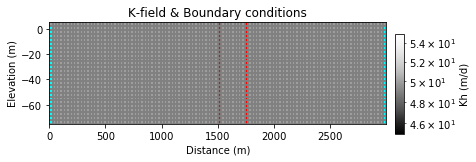

FloPy is using the following  executable to run the model: /Users/ianpg/Documents/ProjectsLocal/SyntheticSWI/bin/modflow_macOS/swt_v4

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition that neither the U.S. Geological Survey nor
 the United States Government may be held liable for any
 damages resulting from their authorized or unauthorized
 use.


 Using NAME file: homogenous.nam                                                                                                                                                                                          
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/01/28 20:52

KeyboardInterrupt: 

In [117]:
# %debug
it = 0
update_run_model(varlist,it,homogenous=1,runyn=True,plotyn=True,silent=False)

In [115]:
varlist

{'head_inland_sum': array([-0.64127579, -0.30764306]),
 'head_inland_wint': array([3.43124452e-04, 9.06997718e-01]),
 'CF_glob': array([0.21740471, 0.17387088]),
 'CF_var': array([0.01012675, 0.01793248]),
 'hk_var': array([0.02049302, 0.03395781]),
 'seed': array([1, 2]),
 'hk_mean': array([1.69897, 1.69897]),
 'por_mean': array([0.34191945, 0.36852195]),
 'por_var': array([3.56295625e-05, 2.34429694e-03]),
 'vario_type': ['Gaussian', 'Exponential'],
 'corr_len': array([752.85063263, 562.97860178]),
 'corr_len_zx': array([0.06028208, 0.02263482]),
 'corr_len_yx': array([0.27829134, 0.82067011]),
 'clay_lyr_yn': array([ True, False]),
 'vka': array([0.81261963, 0.13816077]),
 'al': array([10.41123572, 17.31390301]),
 'dmcoef': array([1.39873208e-06, 1.40610191e-06]),
 'rech': array([0.0010233 , 0.00016563]),
 'rech_farm': array([0.15057921, 0.13895983]),
 'wel': array([[234.7600005 , 129.04996269],
        [ 78.7990356 ,  97.4091256 ],
        [ 69.35697447, 303.58791328],
        [129

In [97]:
varlist['wel'][it]

array([469.52000099, 258.09992537])

In [16]:
for it in range(tot_it):
    update_run_model(varlist, it)
    print('Finished iteration ', it + 1, 'out of ', tot_it)

save_obj(m.MC_file.parent, varlist, 'varlist_success')
save_obj(m.MC_file.parent, m.dis.get_node_coordinates(), 'yxz')
print('Saved file ', m.MC_file.parent.joinpath('varlist_success.pkl'))
print('Saved file ', m.MC_file.parent.joinpath('yxz.pkl'))


****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfghb.ModflowGhb'> <class 'flopy.modflow.mfghb.ModflowGhb'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfwel.ModflowWel'> <class 'flopy.modflow.mfwel.ModflowWel'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfriv.ModflowRiv'> <class 'flopy.modflow.mfriv.ModflowRiv'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...
****Warning -- two packages of the same type: 

In [108]:
hk_grid[wel_cells]

IndexError: index 23 is out of bounds for axis 0 with size 20

In [199]:
tot_it = 10


['Exponential',
 'Exponential',
 'Exponential',
 'Exponential',
 'Exponential',
 'Exponential',
 'Exponential',
 'Exponential',
 'Exponential',
 'Gaussian']

mean: 79.18194896304237 
var: 8491.16106775236 
max: 1069.9626809512677 
min: 2.318432515055956 



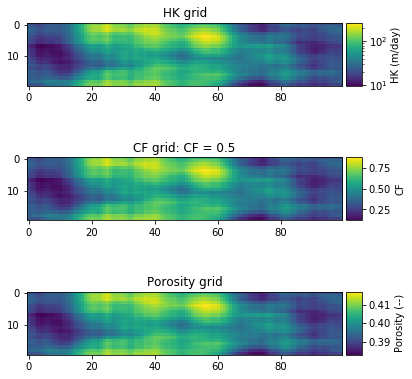

In [194]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
def normal_transform(data1,mu1,mu2,sig1,sig2):
    a = sig2/sig1
    b = mu2 - mu1 * a
    return a*data1 + b


seed=1
CF_glob = .5 #Range of [.2,.9]
CF_var = .05 #Range of [.001, 0.05]
hk_mean = np.log10(50) #Fixed at log10(50)
hk_var = 0.175 #Range: .005, .175
por_mean = .4 #Range [0.2, 0.4]
por_var = 0.0001 #Range: .0001, .005

CF_grid = simulationFFT.simulFFT(nlay,nrow,ncol,CF_glob,CF_var,'Exponential',3,50,50,seed=seed)
hk_grid = 10**normal_transform(CF_grid,CF_glob,hk_mean,np.sqrt(CF_var),np.sqrt(hk_var))
por_grid = normal_transform(CF_grid,CF_glob,por_mean,np.sqrt(CF_var),np.sqrt(por_var))

CF_grid[CF_grid > 1.] = 1.
CF_grid[CF_grid < 0.] = 0.
por_grid[por_grid > 1.] = .99
por_grid[por_grid < 0.] = 0.01

# hk_grid = 10**simulationFFT.simulFFT(nlay,nrow,ncol,hk_mean,hk_var,'Exponential',3,50,50,seed=seed)


f,axs = plt.subplots(3,1,figsize=(6,7))

plt.sca(axs.flatten()[0])
ax = plt.gca()
grid = plt.imshow(hk_grid[:,0,:],cmap='viridis',norm=LogNorm())
plt.title('HK grid')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(grid, cax=cax)
cb.set_label( 'HK (m/day)')

plt.sca(axs.flatten()[1])
ax = plt.gca()
grid = plt.imshow(CF_grid[:,0,:],cmap='viridis')
plt.title('CF grid: CF = {}'.format(CF_glob))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(grid, cax=cax)
cb.set_label( 'CF')

plt.sca(axs.flatten()[2])
ax = plt.gca()
grid = plt.imshow(por_grid[:,0,:],cmap='viridis')
plt.title('Porosity grid')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(grid, cax=cax)
cb.set_label( 'Porosity (--)')


print('mean: {} \n'
     'var: {} \n' 
     'max: {} \n' 
     'min: {} \n'.format(hk_grid.mean(),hk_grid.var(),hk_grid.max(), hk_grid.min()))

(array([  154.,  1324.,  4139.,  7902., 12252., 12661.,  8137.,  3964.,
         1199.,   268.]),
 array([0.36811667, 0.37448526, 0.38085385, 0.38722245, 0.39359104,
        0.39995964, 0.40632823, 0.41269683, 0.41906542, 0.42543402,
        0.43180261]),
 <a list of 10 Patch objects>)

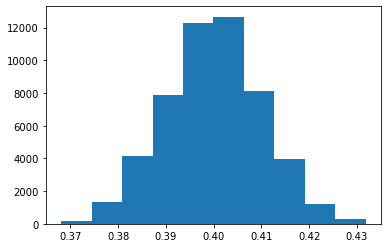

In [191]:
por_mean = .4 #Range [0.2, 0.4]
por_var = 0.0001 #Range: .0001, .005

CF_grid = simulationFFT.simulFFT(nlay,nrow,ncol,CF_glob,CF_var,'Exponential',3,50,50,seed=seed)
hk_grid = 10**normal_transform(CF_grid,CF_glob,hk_mean,np.sqrt(CF_var),np.sqrt(hk_var))
por_grid = normal_transform(CF_grid,CF_glob,por_mean,np.sqrt(CF_var),np.sqrt(por_var))

# plt.hist(CF_grid.flatten())
# plt.show()
# plt.hist((hk_grid.flatten()))
# plt.show()
plt.hist(por_grid.flatten())



In [71]:
def cf2hk(CF_grid,hk_low,hk_high):
    return CF_grid*np.log10(hk_high/hk_low) + np.log10(hk_low)

In [120]:
def cf2hk(CF_grid,CF_glob,CF_var,log_hk_mean,log_hk_var):
    return ((CF_grid - CF_glob + log_hk_mean)/np.sqrt(CF_var) + np.sqrt(log_hk_var))

In [155]:
CF_glob = .2
hk_var = 1.1
CF_var = .001
hk_mean = np.log10(50)
hk_var = .001
hk_grid = cf2hk(CF_grid,CF_glob,CF_var,hk_mean,hk_var)

(array([5.1243e+04, 4.2900e+02, 1.2700e+02, 7.0000e+01, 5.2000e+01,
        4.5000e+01, 1.1000e+01, 1.1000e+01, 9.0000e+00, 3.0000e+00]),
 array([3.71055004e+50, 8.67030445e+55, 1.73405718e+56, 2.60108391e+56,
        3.46811065e+56, 4.33513738e+56, 5.20216412e+56, 6.06919085e+56,
        6.93621759e+56, 7.80324432e+56, 8.67027106e+56]),
 <a list of 10 Patch objects>)

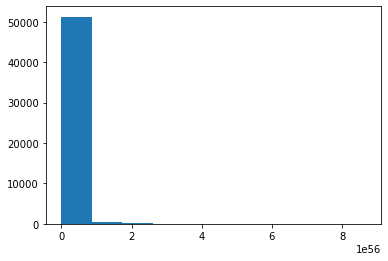

In [119]:
plt.hist(hk_grid.flatten())

(array([ 8717., 12140., 11353.,  7725.,  4545.,  2986.,  1844.,  1048.,
          605.,  1037.]),
 array([ 31.54786722,  59.94094773,  88.33402823, 116.72710873,
        145.12018923, 173.51326973, 201.90635023, 230.29943074,
        258.69251124, 287.08559174, 315.47867224]),
 <a list of 10 Patch objects>)

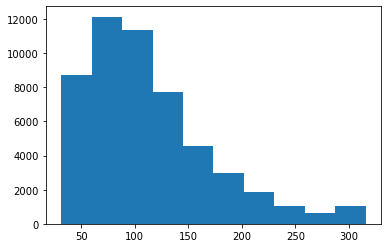

In [159]:
plt.hist(10**hk_grid.flatten())

(array([2003., 3019., 4889., 6857., 9092., 9212., 7251., 4921., 2870.,
        1886.]),
 array([0.76355566, 0.95063853, 1.1377214 , 1.32480427, 1.51188713,
        1.69897   , 1.88605287, 2.07313574, 2.26021861, 2.44730148,
        2.63438435]),
 <a list of 10 Patch objects>)

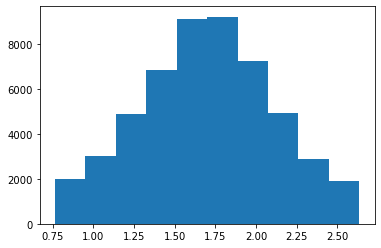

In [175]:
plt.hist(hk_grid.flatten())

In [179]:
hk_grid.var()

0.16946523770426536

In [116]:
from pymatsolver import Pardiso


In [124]:
import pymatsolver
pymatsolver?

Type:        module
String form: <module 'pymatsolver' from '/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/pymatsolver/__init__.py'>
File:        ~/anaconda/envs/SWIenv/lib/python3.6/site-packages/pymatsolver/__init__.py
Docstring:   <no docstring>


In [125]:
Pardiso?

Init signature: Pardiso(A, **kwargs)
Docstring:     
Pardiso Solver

Wrapped by David Marchant

    https://github.com/dwfmarchant/pyMKL


documentation::

    http://www.pardiso-project.org/
File:           ~/anaconda/envs/SWIenv/lib/python3.6/site-packages/pymatsolver/direct.py
Type:           type
Subclasses:     


In [137]:
def unpack_success_files(success_dir):
    from numpy import asarray
    nams = [p.name for p in Path(success_dir).iterdir() if 
            (p.name.startswith('success') and p.name.endswith('.pkl'))]
    success_list= []
    for n in nams:
        success_list.append(load_obj(success_dir,n[:-4]))
    return asarray(success_list),nams


unpack_success_files('/Users/ianpg/Documents/ProjectsLocal/SWIsmall/data/')

(array([[345,   1],
        [423,   1],
        [437,   1],
        ...,
        [406,   1],
        [360,   1],
        [348,   1]]),
 ['success345.pkl',
  'success423.pkl',
  'success437.pkl',
  'success351.pkl',
  'success379.pkl',
  'success386.pkl',
  'success7.pkl',
  'success392.pkl',
  'success147.pkl',
  'success153.pkl',
  'success184.pkl',
  'success190.pkl',
  'success231.pkl',
  'success225.pkl',
  'success219.pkl',
  'success48.pkl',
  'success74.pkl',
  'success60.pkl',
  'success61.pkl',
  'success75.pkl',
  'success49.pkl',
  'success218.pkl',
  'success224.pkl',
  'success230.pkl',
  'success191.pkl',
  'success185.pkl',
  'success152.pkl',
  'success146.pkl',
  'success393.pkl',
  'success6.pkl',
  'success387.pkl',
  'success378.pkl',
  'success436.pkl',
  'success350.pkl',
  'success344.pkl',
  'success422.pkl',
  'success352.pkl',
  'success434.pkl',
  'success420.pkl',
  'success346.pkl',
  'success408.pkl',
  'success391.pkl',
  'success385.pkl',
  'success4.pkl

In [135]:
success_dir = '/Users/ianpg/Documents/ProjectsLocal/SWIsmall/data/'



In [136]:
nams

['success345.pkl',
 'success423.pkl',
 'success437.pkl',
 'success351.pkl',
 'success379.pkl',
 'success386.pkl',
 'success7.pkl',
 'success392.pkl',
 'success147.pkl',
 'success153.pkl',
 'success184.pkl',
 'success190.pkl',
 'success231.pkl',
 'success225.pkl',
 'success219.pkl',
 'success48.pkl',
 'success74.pkl',
 'success60.pkl',
 'success61.pkl',
 'success75.pkl',
 'success49.pkl',
 'success218.pkl',
 'success224.pkl',
 'success230.pkl',
 'success191.pkl',
 'success185.pkl',
 'success152.pkl',
 'success146.pkl',
 'success393.pkl',
 'success6.pkl',
 'success387.pkl',
 'success378.pkl',
 'success436.pkl',
 'success350.pkl',
 'success344.pkl',
 'success422.pkl',
 'success352.pkl',
 'success434.pkl',
 'success420.pkl',
 'success346.pkl',
 'success408.pkl',
 'success391.pkl',
 'success385.pkl',
 'success4.pkl',
 'success150.pkl',
 'success144.pkl',
 'success178.pkl',
 'success193.pkl',
 'success187.pkl',
 'success226.pkl',
 'success88.pkl',
 'success232.pkl',
 'success63.pkl',
 'succe